In [2]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import os
import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import csv

In [3]:
use_google_colab = False

if use_google_colab==True:
    from google.colab import drive
    drive.mount('/content/drive')
    path_to_project = '/content/drive/MyDrive/School/1. University/Year 4/Semester 2/APS360 - Applied Fundamentals of Deep Learning/Project/'
else:
    # When using on local machine. Folder 'split_data' must be in the same dir as this file.
    path_to_project=""
    
print(path_to_project)

In [4]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

mps


In [5]:
def count_images_and_percentage_with_partition(root):
    partitions = ['train', 'val', 'test']
    classes = ['Glass', 'Metal', 'Paper', 'Plastic']
    total_images = 0
    partition_totals = {}
    counts = {}

    # Count the images in each partition and class
    for partition in partitions:
        partition_counts = {}
        partition_total = 0
        for class_name in classes:
            class_path = os.path.join(root, 'split_data', partition, class_name)
            image_files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
            count = len(image_files)
            partition_counts[class_name] = count
            partition_total += count
        counts[partition] = partition_counts
        partition_totals[partition] = partition_total
        total_images += partition_total

    # Print counts and percentages
    for partition, partition_counts in counts.items():
        print(f"'{partition}' partition: {partition_totals[partition]} images, {(partition_totals[partition] / total_images) * 100:.2f}% of total")
        for class_name, count in partition_counts.items():
            percentage = (count / partition_totals[partition]) * 100
            print(f" - {class_name}: {count} images, {percentage:.2f}% of partition")
        print()

    print(f"Total images across all partitions: {total_images}")

In [6]:
count_images_and_percentage_with_partition(path_to_project)

'train' partition: 2654 images, 69.97% of total
 - Glass: 649 images, 24.45% of partition
 - Metal: 683 images, 25.73% of partition
 - Paper: 658 images, 24.79% of partition
 - Plastic: 664 images, 25.02% of partition

'val' partition: 586 images, 15.45% of total
 - Glass: 143 images, 24.40% of partition
 - Metal: 151 images, 25.77% of partition
 - Paper: 145 images, 24.74% of partition
 - Plastic: 147 images, 25.09% of partition

'test' partition: 553 images, 14.58% of total
 - Glass: 136 images, 24.59% of partition
 - Metal: 142 images, 25.68% of partition
 - Paper: 137 images, 24.77% of partition
 - Plastic: 138 images, 24.95% of partition

Total images across all partitions: 3793


In [7]:
def calculate_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0

    for images, _ in loader:
        images_count = images.size(0)
        images = images.view(images_count, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images_count += images_count

    mean /= total_images_count
    std /= total_images_count

    return mean, std

In [8]:
# Modified from Lab 3
def get_trash_data_loader_with_normalization(batch_size, img_dim, path_to_project, device):
    """
    Returns data loaders for the training, validation, and test datasets for the trash classification project.

    Args:
        batch_size: The number of samples per batch to load.
        img_dim: Size to resize the incoming images. E.g., AlexNet takes 224x224 images.
        path_to_project: Path to the project folder containing the 'split_data' folder.
        device: The device to use for the DataLoader. Either 'cuda' or 'cpu'.

    Returns:
        train_loader: DataLoader for the training set
        val_loader: DataLoader for the validation set
        test_loader: DataLoader for the test set
    """
    # Initial Transforms without normalization to calculate mean and std
    initial_transform = transforms.Compose([
        transforms.Resize((img_dim, img_dim)),
        transforms.ToTensor(),
    ])
    
    # Load the training data without any augmentation to calculate the mean and std
    train_dataset = datasets.ImageFolder(os.path.join(path_to_project, 'split_data/train'), transform=initial_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=device == 'cuda')

    # Calculate mean and std
    mean, std = calculate_mean_std(train_loader)
    
    # Transforms with normalization and data augmentation
    transform_with_normalization = transforms.Compose([
        transforms.Resize((img_dim, img_dim)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean.tolist(), std.tolist()),
    ])

    # Paths to the folders. Each class needs to have its own folder. Eg split_data/train/Glass
    train_dataset = datasets.ImageFolder(os.path.join(path_to_project, 'split_data/train'), transform=transform_with_normalization)
    val_dataset = datasets.ImageFolder(os.path.join(path_to_project, 'split_data/val'), transform=transform_with_normalization)
    test_dataset = datasets.ImageFolder(os.path.join(path_to_project, 'split_data/test'), transform=transform_with_normalization)

    # Recreate the loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=device == 'cuda')
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=device == 'cuda')
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=device == 'cuda')

    return train_loader, val_loader, test_loader

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


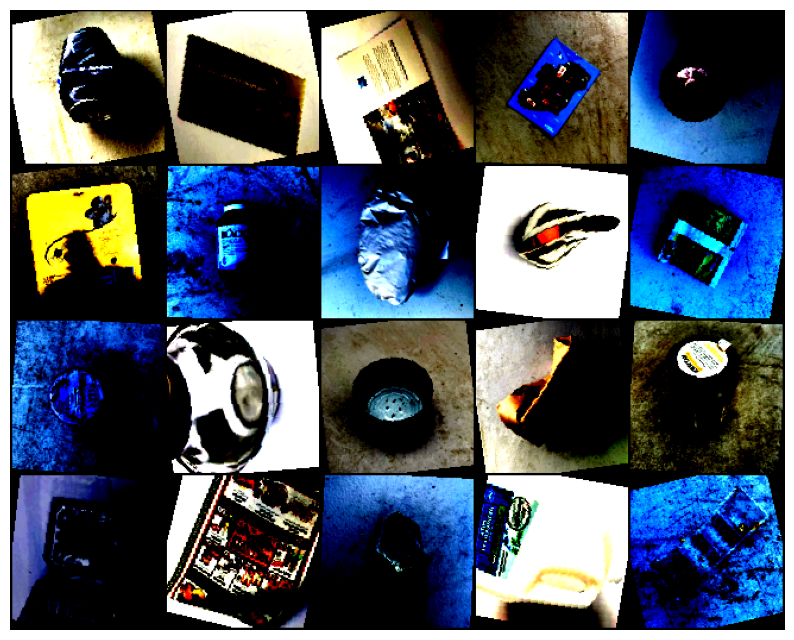

In [9]:
# Visualize a few sample images from the dataset 
train_loader_for_vis, _, _ = get_trash_data_loader_with_normalization(batch_size=20, img_dim=128, path_to_project=path_to_project, device=device)

# Get a batch of training data
inputs, classes = next(iter(train_loader_for_vis))

# Make a 5x5 grid from the batch of images
out = torchvision.utils.make_grid(inputs, nrow=5)

plt.figure(figsize=(10,10))
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.show()

In [10]:
class LargeNet256(nn.Module):
    def __init__(self):
        super(LargeNet256, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=2, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, stride=1, padding=0)
        self.fc1 = nn.Linear(in_features=10 * 30 * 30, out_features=32)
        self.fc2 = nn.Linear(in_features=32, out_features=4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) #convolution, relu activation, max pooling
        x = self.pool(F.relu(self.conv2(x))) #convolution, relu activation, max pooling
        x = x.view(-1, 10 * 30 * 30)
        x = F.relu(self.fc1(x)) #linear, relu activation
        x = self.fc2(x) #linear

        return x

In [11]:
class OptimizedCNN256(nn.Module):
    def __init__(self):
        super(OptimizedCNN256, self).__init__()
        
        # [input - kernel + 2*padding] / stride + 1

        # Conv #1
        # [3, 256, 256] -> [5, 252, 252]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=1, padding=0)
        
        # MaxPooling
        # [5, 252, 252] -> [5, 126, 126]
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv #2
        # [5, 126, 126] -> [10, 122, 122]
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=5, stride=1, padding=0)

        # After the first layer: (256 - 5 + 1) / 1 = 252, then pooled: 252 / 2 = 126
        # After the second layer: (126 - 5 + 1) / 1 = 122, then pooled: 122 / 2 = 61
        self.num_flat_features = 10 * 61 * 61

        # First fully connected layer
        self.fc1 = nn.Linear(self.num_flat_features, 120)

        # Second fully connected layer
        self.fc2 = nn.Linear(120, 84)
        
        # Output layer
        self.fc3 = nn.Linear(84, 4)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [12]:
class OptimizedCNN128(nn.Module):
    def __init__(self):
        super(OptimizedCNN128, self).__init__()
        
        # Conv #1: [3, 128, 128] -> [5, 124, 124]
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5, stride=1, padding=0)
        
        # MaxPooling: [5, 124, 124] -> [5, 62, 62]
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Conv #2: [5, 62, 62] -> [10, 58, 58]
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=5, stride=1, padding=0)

        # Adjusted for input size of 128x128
        self.num_flat_features = 10 * 29 * 29  # 8410

        # First fully connected layer
        self.fc1 = nn.Linear(self.num_flat_features, 120)

        # Second fully connected layer
        self.fc2 = nn.Linear(120, 84)
        
        # Output layer
        self.fc3 = nn.Linear(84, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.num_flat_features)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

In [13]:
class ModifiedAlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super(ModifiedAlexNet, self).__init__()
        # Using the original AlexNet configuration with modifications
        self.features = nn.Sequential(
            # Convolutional Layer #1: Input (227x227x3) -> Output (55x55x96)
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True), # Inplace operation to reduce memory usage
            nn.MaxPool2d(kernel_size=3, stride=2), # Input (55x55x96) -> Output (27x27x96)
            # nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2), # Doesn't work yet on MPS
            
            # Convolutional Layer #2: Input (55x55x96) -> Output (27x27x256)
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # nn.LocalResponseNorm(size=5, alpha=1e-4, beta=0.75, k=2), # Doesn't work yet on MPS
            
            # Convolutional Layer #3: Input (27x27x256) -> Output (13x13x384)
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            
            # Max Pooling Layer: Input (13x13x384) -> Output (6x6x384)
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        # Adaptive Average Pooling Layer: Input (6x6x384) -> Output (6x6x384)
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        
        # FCs
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(384 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        
        return x

In [14]:
# https://blog.paperspace.com/alexnet-pytorch/
class AlexNet(nn.Module):
    def __init__(self, num_classes=4):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [15]:
def plot_training_curve(config, train_losses, val_losses, train_accs, val_accs, filename):
    """Plot training and validation losses and accuracies, then save the plot."""
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Training Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight')
    plt.close()

In [16]:
def train(model, train_loader, valid_loader, config):
    """ Training loop and CSV logging."""
    torch.manual_seed(42)
    
    folder_name = f"{model.__class__.__name__}_lr={config['learning_rate']}_epochs={config['num_epochs']}_batch={config['batch_size']}"
    folder_path = os.path.join(path_to_project, folder_name)
    
    # Create the folder if it does not exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate']) 

    # Keep track of the best validation loss and accuracy
    best_valid_loss = float('inf')
    best_valid_acc = 0

    # Lists to store the training and validation losses and accuracies
    train_losses, valid_losses, train_accs, valid_accs = [], [], [], []
    
    # Initialize a list to store CSV data
    csv_data = [["Epoch", "Train Loss", "Valid Loss", "Train Acc", "Valid Acc"]]

    for epoch in range(config['num_epochs']):
        start_of_epoch = time.time()
        
        model.train()  # Set model to training mode
        total_train_loss, total_train_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train_correct += (predicted == labels).sum().item()

        # Calculate average training loss for the epoch
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Calculate training accuracy
        train_accuracy = total_train_correct / (len(train_loader.dataset))
        train_accs.append(train_accuracy)

        # Set model to evaluation mode
        model.eval()
        total_valid_loss, total_valid_correct = 0, 0

        # Validation loop
        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                total_valid_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_valid_correct += (predicted == labels).sum().item()

        avg_valid_loss = total_valid_loss / len(valid_loader)
        valid_accuracy = total_valid_correct / (len(valid_loader.dataset))
        valid_losses.append(avg_valid_loss)
        valid_accs.append(valid_accuracy)

        # Update best validation loss and accuracy
        if avg_valid_loss < best_valid_loss:
            best_valid_loss = avg_valid_loss
            best_valid_acc = valid_accuracy

        # Append epoch data to CSV data list
        csv_data.append([epoch+1, avg_train_loss, avg_valid_loss, train_accuracy, valid_accuracy])
                
        # Print epoch data
        time_elapsed = time.time() - start_of_epoch
        print(f"Epoch {epoch+1}/{config['num_epochs']} | Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_valid_loss:.4f} | Train Acc: {train_accuracy:.4f} | Validation Acc: {valid_accuracy:.4f} | Time: {time_elapsed:.4f}")

    # Save the CSV file
    csv_filename = os.path.join(folder_path, f"training_data_{folder_name}.csv")
    with open(csv_filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(csv_data)
    
    # Save the training curve plot
    plot_filename = os.path.join(folder_path, f"training_curve_{folder_name}.png")
    plot_training_curve(config, train_losses, valid_losses, train_accs, valid_accs, plot_filename)
    
    return best_valid_loss, best_valid_acc

In [17]:
class ModelTrainer:
    """Class to train and evaluate models with different hyperparameters.
    
    Args:
        model_class: The model class to train.
        hyperparameter_configs: A list of dictionaries, each containing hyperparameters to train the model with.
        img_dim: The size to resize the input images.
        path_to_project: The path to the project folder containing the 'split_data' folder.
        device: The device to use for training. Either 'cuda' or 'cpu'.
    """
    
    def __init__(self, model_class, hyperparameter_configs, img_dim, path_to_project, device='cpu'):
        self.model_class = model_class
        self.hyperparameter_configs = hyperparameter_configs
        self.img_dim = img_dim
        self.path_to_project = path_to_project
        self.device = device
        self.performance_tracking = []

    def train_and_evaluate(self):
        for config in self.hyperparameter_configs:
            start = time.time()

            model = self.model_class().to(self.device)
            print(f"Training {model.__class__.__name__} model with config: {config} on {self.device}...")

            train_loader, val_loader, _ = get_trash_data_loader_with_normalization(
                batch_size=config["batch_size"], img_dim=self.img_dim, path_to_project=self.path_to_project, device=self.device)

            best_valid_loss, best_valid_acc = train(model, train_loader, val_loader, config)

            # Track performance
            self.performance_tracking.append({
                'config': config,
                'best_valid_acc': best_valid_acc,
                'best_valid_loss': best_valid_loss
            })

            # Save the model
            self.save_model(model, config)

            # Report time elapsed
            self.report_time_elapsed(start)

        self.report_best_performance()

    def save_model(self, model, config):
        folder_name = f"{model.__class__.__name__}_lr={config['learning_rate']}_epochs={config['num_epochs']}_batch={config['batch_size']}"
        folder_path = os.path.join(self.path_to_project, folder_name)
        model_save_path = os.path.join(folder_path, f"model_{folder_name}.pth")
        os.makedirs(folder_path, exist_ok=True)
        torch.save(model.state_dict(), model_save_path)
        print(f"Model saved to {model_save_path}")

    def report_time_elapsed(self, start_time):
        time_elapsed = (time.time() - start_time) / 60
        if time_elapsed < 1:
            print(f"{time_elapsed * 60:.2f} seconds")
        else:
            minutes, seconds = divmod(time_elapsed * 60, 60)
            print(f"{int(minutes)} minutes and {seconds:.2f} seconds")

    def report_best_performance(self, print_info=True):
        best_performance = sorted(self.performance_tracking, key=lambda x: x['best_valid_loss'])[0]
        if print_info:
            print("Best performing model configuration:", best_performance['config'])
            print("With Validation Loss:", best_performance['best_valid_loss'], "and Validation Accuracy:", best_performance['best_valid_acc'])
        return best_performance
    
    def load_model(self, model_class, model_path):
        model = model_class().to(self.device)
        model.load_state_dict(torch.load(model_path, map_location=self.device))
        model.eval()
        return model
    
    def evaluate_on_test_set(self):
        print("Evaluating the best performing model on the test set...")
        best_performance = self.report_best_performance(print_info=False)
        best_model_name = f"{self.model_class.__name__}_lr={best_performance['config']['learning_rate']}_epochs={best_performance['config']['num_epochs']}_batch={best_performance['config']['batch_size']}"
        best_model_path = os.path.join(self.path_to_project, f"{best_model_name}/model_{best_model_name}.pth")

        model = self.load_model(self.model_class, best_model_path)

        _, _, test_loader = get_trash_data_loader_with_normalization(batch_size=128, img_dim=self.img_dim, path_to_project=self.path_to_project, device=self.device)

        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Accuracy of the network on the test images ({total} images): {100 * correct / total:.2f}%')


### Standard AlexNet CNN as a "benchmark"

In [17]:
hyperparameter_configs = [
    # {'learning_rate': 1e-3, 'num_epochs': 120, 'batch_size': 128},    # Done
    # {'learning_rate': 1e-3, 'num_epochs': 200, 'batch_size': 128},    # Done
    # {'learning_rate': 1e-4, 'num_epochs': 120, 'batch_size': 128},    # Done
    # {'learning_rate': 1e-4, 'num_epochs': 200, 'batch_size': 128},    # Crashed
]

# trainer = ModelTrainer(AlexNet, hyperparameter_configs, img_dim=227, path_to_project=path_to_project, device=device)
# trainer.train_and_evaluate()
# trainer.evaluate_on_test_set()

Training AlexNet model with config: {'learning_rate': 0.001, 'num_epochs': 120, 'batch_size': 128} on mps...
Epoch 1/120 | Train Loss: 6.0116 | Validation Loss: 1.4471 | Train Acc: 0.2619 | Validation Acc: 0.2577 | Time: 30.4638
Epoch 2/120 | Train Loss: 1.3717 | Validation Loss: 1.3613 | Train Acc: 0.2928 | Validation Acc: 0.3072 | Time: 30.4229
Epoch 3/120 | Train Loss: 1.3433 | Validation Loss: 1.3367 | Train Acc: 0.3176 | Validation Acc: 0.3362 | Time: 30.2048
Epoch 4/120 | Train Loss: 1.3087 | Validation Loss: 1.3058 | Train Acc: 0.3666 | Validation Acc: 0.3771 | Time: 29.9926
Epoch 5/120 | Train Loss: 1.2846 | Validation Loss: 1.3306 | Train Acc: 0.3651 | Validation Acc: 0.3481 | Time: 29.9721
Epoch 6/120 | Train Loss: 1.2673 | Validation Loss: 1.2755 | Train Acc: 0.3715 | Validation Acc: 0.3857 | Time: 29.9787
Epoch 7/120 | Train Loss: 1.2555 | Validation Loss: 1.2734 | Train Acc: 0.3949 | Validation Acc: 0.3959 | Time: 30.1242
Epoch 8/120 | Train Loss: 1.2507 | Validation Loss:

BlockingIOError: [Errno 35] Resource temporarily unavailable

### Modified AlexNet CNN, which has the following changes:
1. 5 -> 3 Convolutional Layers
2. Use padding in the Convolutional Layers
3. Don't use Batch Normalization in the Convolutional Layers
4. Pooling layers after the 1st, 2nd and 3rd Convolutional Layers instead of after the 1st, 2nd and 5th Convolutional Layers.
5. Adaptive average pooling layer before the fully connected layers.

In [18]:
hyperparameter_configs = [
    {'learning_rate': 1e-3, 'num_epochs': 120, 'batch_size': 128},
    {'learning_rate': 1e-3, 'num_epochs': 200, 'batch_size': 128},
    # {'learning_rate': 1e-4, 'num_epochs': 120, 'batch_size': 128},
    # {'learning_rate': 1e-4, 'num_epochs': 200, 'batch_size': 128},
]

trainer = ModelTrainer(ModifiedAlexNet, hyperparameter_configs, img_dim=227, path_to_project=path_to_project, device=device)
trainer.train_and_evaluate()
trainer.evaluate_on_test_set()

Training ModifiedAlexNet model with config: {'learning_rate': 0.001, 'num_epochs': 120, 'batch_size': 128} on mps...
Epoch 1/120 | Train Loss: 2.1554 | Validation Loss: 1.3419 | Train Acc: 0.2852 | Validation Acc: 0.3157 | Time: 28.6962
Epoch 2/120 | Train Loss: 1.3222 | Validation Loss: 1.3065 | Train Acc: 0.3489 | Validation Acc: 0.3720 | Time: 28.5765
Epoch 3/120 | Train Loss: 1.2871 | Validation Loss: 1.2738 | Train Acc: 0.3896 | Validation Acc: 0.4283 | Time: 28.5535
Epoch 4/120 | Train Loss: 1.2345 | Validation Loss: 1.2257 | Train Acc: 0.4337 | Validation Acc: 0.4266 | Time: 28.5604
Epoch 5/120 | Train Loss: 1.2279 | Validation Loss: 1.1434 | Train Acc: 0.4442 | Validation Acc: 0.4915 | Time: 28.5097
Epoch 6/120 | Train Loss: 1.1722 | Validation Loss: 1.1253 | Train Acc: 0.4710 | Validation Acc: 0.5427 | Time: 28.5859
Epoch 7/120 | Train Loss: 1.1471 | Validation Loss: 1.0806 | Train Acc: 0.4830 | Validation Acc: 0.5205 | Time: 28.5215
Epoch 8/120 | Train Loss: 1.1154 | Validati

KeyboardInterrupt: 

### OptimizedCNN128

In [17]:
hyperparameter_configs = [
    {'learning_rate': 1e-3, 'num_epochs': 120, 'batch_size': 128},
    {'learning_rate': 1e-3, 'num_epochs': 200, 'batch_size': 128},
    {'learning_rate': 1e-4, 'num_epochs': 120, 'batch_size': 128},
    {'learning_rate': 1e-4, 'num_epochs': 200, 'batch_size': 128},
]

trainer = ModelTrainer(OptimizedCNN128, hyperparameter_configs, img_dim=128, path_to_project=path_to_project, device=device)
trainer.train_and_evaluate()
trainer.evaluate_on_test_set()

Training OptimizedCNN128 model with config: {'learning_rate': 0.001, 'num_epochs': 120, 'batch_size': 128} on mps...
Epoch 1/120 | Train Loss: 1.6411 | Validation Loss: 1.3129 | Train Acc: 0.3410 | Validation Acc: 0.4010 | Time: 25.3617


KeyboardInterrupt: 